 # Training of the AI model with Google Colab for faster training

#### Importing face mask dataset from Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Unzipping images:

In [2]:
import os
from zipfile import ZipFile

path = r'/content/drive/My Drive/Data/FaceMask_Dataset'

for zip in os.listdir(path):
  file_name = os.path.join(path, zip)
  print('Unziping: ' + file_name)
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/OkFaceMask.zip
Done
Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/NoFaceMask.zip
Done
Unziping: /content/drive/My Drive/Data/FaceMask_Dataset/BadFaceMask.zip
Done


#### Preparing the input data (images) and the output (prediction):

In [3]:
import pathlib
import cv2
import numpy as np

imageSize = 100
channel = 1 
path = '/content'
X = [] # Data
Y = [] # Label

dict_label  = { 'NoFaceMask':0 , 'OkFaceMask':1 , 'BadFaceMask':2 }

faceMaskDirectories = [str(directory) for directory in pathlib.Path(path).glob('*') if 'Mask' in str(directory)]

for directory in faceMaskDirectories:
  for image in pathlib.Path(directory).glob('*/*'):
    if image.suffix in {'.jpg', '.png'}:
      img = cv2.imread(str(image), 0)
      X.append(img)
      Y.append(dict_label[directory.split('/')[-1]])

X = np.asarray(X)
Y = np.asarray(Y)
print('Array X type: ' , type(X))
print('Array Y type: ' , type(Y))
print('Array X shape:' , X.shape)
print('Array Y shape:' , Y.shape)

Array X type:  <class 'numpy.ndarray'>
Array Y type:  <class 'numpy.ndarray'>
Array X shape: (14339, 100, 100)
Array Y shape: (14339,)


#### Image and label:

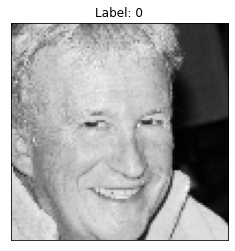

In [4]:
import matplotlib.pyplot as plt
exampleImage = 5000
plt.imshow(X[exampleImage], cmap='Greys_r')
plt.title('Label: ' + str(Y[exampleImage]))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

#### Images per label:

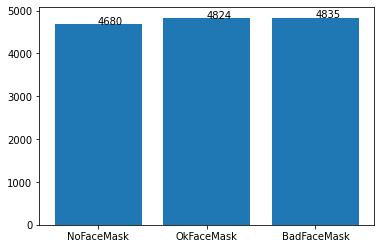

In [5]:
labels, counts = np.unique(Y, return_counts=True)
labels = np.asarray(list(dict_label.keys()))
for i in range(len(labels)):
  plt.text(x=labels[i] , y =counts[i], s=counts[i], fontdict=dict(fontsize=10))
plt.bar(labels, counts, align='center')
plt.show()

#### Splitting dataset:

In [6]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Data reshape for the model entry
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))

# Converting vector to binary class matrix
Y = to_categorical(Y)

# Normalization
X = X/255.0

# Dataset split into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25, random_state=42)

#### Using data augmentation:

In [7]:
from keras.preprocessing.image import ImageDataGenerator  

datagen_train = ImageDataGenerator(zoom_range=[1,1.6], height_shift_range=0.3, width_shift_range=[-20,20], rotation_range=15, horizontal_flip=True)
datagen_train.fit(X_train)

datagen_val = ImageDataGenerator(zoom_range=[1,1.6], height_shift_range=0.3, width_shift_range=[-20,20], rotation_range=15, horizontal_flip=True)
datagen_val.fit(X_test)

generator_train = datagen_train.flow(X_train, Y_train, batch_size=64)
generator_val = datagen_val.flow(X_test, Y_test, batch_size=64)

#### Creating CNN model:

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import Activation
from keras.layers import SpatialDropout2D
import keras
keras.backend.clear_session()

model=Sequential()

model.add(Conv2D(2,(3,3), input_shape=(100, 100, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

opt = Adam()
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])